In [417]:
import numpy as np
from binomial_ssm_csmc import particle_filter, bssm_log_likelihood
from utils.data import load_network
from utils.vis import plot_raster
from numba import jit

In [719]:
network_df = load_network()
obs_1ms_df = network_df.apply(lambda x: x.sum(0))
n_trials_1ms_df = network_df.apply(lambda x: x.shape[0])

n_ms = 5
obs_all = obs_1ms_df.apply(lambda x: x.reshape((-1, n_ms)).sum(1)).values.tolist()
n_trials_all = n_trials_1ms_df.values * n_ms
cue_time = 500 // n_ms

In [720]:
#BPF
@jit(nopython=True, nogil=True)
def calc_bssm_log_like_bpf(ob, param, n, n_particles):
    n_trials = n_trials_all[n]
    jump, log_var = param
    p_init = ob[:cue_time].sum() / (500 * n_trials // n_ms) 
    mean_init = np.log(p_init / (1 - p_init))
    var = np.exp(log_var)
    return particle_filter(ob[cue_time:], var=var, n_particles=n_particles, n_trials=n_trials, 
                           mean_init=mean_init+jump, var_init=1e-10)

In [737]:
# cSMC
@jit(nopython=True, nogil=True)
def calc_bssm_log_like_csmc(ob, param, n, n_particles):
    n_trials = n_trials_all[n]
    jump, log_var = param
    p_init = ob[:cue_time].sum() / (500 * n_trials // n_ms) 
    mean_init = np.log(p_init / (1 - p_init))
    var = np.exp(log_var)
    return bssm_log_likelihood(ob[cue_time:], var=var, n_particles=n_particles, n_trials=n_trials, 
                               max_iters=3, mean_init=mean_init+jump, var_init=1e-10, ess_threshold=200)

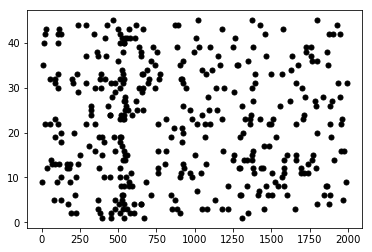

In [822]:
plot_raster(network_df.iloc[25])

In [823]:
%%time
a = []
for _ in range(500):
    _, _, log_likelihoods, _, _ = calc_bssm_log_like_bpf(obs_all[25], np.array([2, -5]), 25, n_particles=1024)
    a.append(log_likelihoods[-1])

CPU times: user 22.5 s, sys: 0 ns, total: 22.5 s
Wall time: 22.5 s


In [829]:
%%time
b = []
for _ in range(500):
    b.append(calc_bssm_log_like_csmc(obs_all[25], np.array([2, -5]), 25, n_particles=64))
print(np.std(b))

0.0250818568248
CPU times: user 17.9 s, sys: 0 ns, total: 17.9 s
Wall time: 17.9 s


In [855]:
np.linspace(-2, 2, 21)

array([-2. , -1.8, -1.6, -1.4, -1.2, -1. , -0.8, -0.6, -0.4, -0.2,  0. ,
        0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ])

In [847]:
np.linspace(-15, 0, 16)

array([-15., -14., -13., -12., -11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,
        -4.,  -3.,  -2.,  -1.,   0.])

In [848]:
16 * 51

816

In [828]:
np.std(a)

0.86010780755224403

In [830]:
np.std(b)

0.025081856824845615